In [361]:
import math, numpy as np, pandas as pd
import jsonrpc_requests as jrpc
import wtfutil
import time
import pathlib
import datetime
import functools
import cubehelix
import multiprocessing
import matplotlib.pyplot as plt

import wtfviz
import pyarrow.parquet as pq
from IPython.core.display import display, HTML
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for a in args:
        if hasattr(a, 'to_html'):
            html_str+=a.to_html()
        else:
            html_str+=a._repr_html_()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
arcs = wtfutil.annotate_rcs

In [444]:
CMAP='gcolor'


In [445]:
def fgentle(x, ceil=0):
    if x == 0: return 1
    p = 2
    ex = np.exp(x/100)
    if ceil == 0:
        if ex > 10: p=1
        if ex > 100: p=0
    else:
        ex = np.ceil(ex)
        p=0
        
    return ('{:.'+str(p)+'f}').format(ex)
fgentle0 = functools.partial(fgentle, ceil=0)
fgentle1 = functools.partial(fgentle, ceil=1)

In [446]:
%%time
# find all full mempools for each day

# calculate lowest feelevel for each day

#d = pd.Series(
#    )[0]

def mp_feelevel(path, tolerance=0.05, init_agg=800, ceil_agg=800, **state):
    try:
        df = pd.read_parquet(path, columns=['satoshi', 'vsize'])
    except:
        print("ERROR", path.name)
        return {}
    
    fa = wtfutil.feeagg(df, init_agg)
    if init_agg != ceil_agg:
        fa = wtfutil.fa_ceilgroup(fa, div=ceil_agg)
    
    
    truth_matrix = -fa.mvs.values.cumsum() + tolerance > 0    
    
    feeidx = np.argmin(truth_matrix) - 1
    if feeidx == -1: # special case, either empty or full
        if np.alltrue(truth_matrix):
            feeidx = len(fa.index)-1
        else:
            feeidx = 0
    
    state['lvl_lowest'] = fa.index[feeidx]
    state['path'] = path
    state['ts_sec'] = pd.Timestamp(int(path.name.split('_')[1]), unit='s')
    #state['fa'] = fa
    
    
    return state

def mp_chained(initial_state, fnchain=[], keepkeys=None):
    state = initial_state

    for fn in fnchain:
        state = fn(**state)

    if keepkeys:
        state = {k: state[k] for k in keepkeys}
    return state


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21.2 µs


In [447]:
%%time
initial_states = []

for ts_day in pd.date_range('2019-01-02', '2019-06-13'):
    pathstr = ts_day.strftime('data/%Y/%m/%d/')
    for path in pathlib.Path(pathstr).glob('*_full.parq'):
        initial_states.append({
            'ts_day': ts_day,
            'path': path
        })

CPU times: user 1.45 s, sys: 520 ms, total: 1.97 s
Wall time: 1.95 s


In [419]:
len(initial_states)

23752

In [420]:
fnchain = [mp_feelevel]
keepkeys = None

p = multiprocessing.Pool()

works = [p.apply_async(mp_chained, (
    state,
    fnchain,
    keepkeys
)) for state in initial_states]


In [421]:
while True:
    pct_ready = sum([w.ready() for w in works])/len(works)
    pct_success = sum([w.ready() and w.successful() for w in works])/len(works)
    print(pct_ready, pct_success)
    if pct_ready == 1: break
    time.sleep(1)
    


0.0634051869316268 0.06412091613337824
0.10070730885820141 0.10184405523745368
0.1377989221960256 0.13809363422027618
0.17489053553384978 0.17547995958235096
0.20903502862916806 0.21012967329067025
0.2457056247894914 0.2473054900639946
0.2769029976423038 0.2777029302795554
0.31028965981812057 0.3113843044796228
0.34287638935668574 0.3435500168406871
0.37643145840350284 0.3777366116537555
0.41061805321657124 0.41238632536207476
0.44598349612664195 0.44779386998989557
0.482990906028966 0.48412765240821826
0.5168827888177837 0.5181458403502863
0.5431121589760862 0.5441226002020882
0.5607106769956214 0.5612158976086224
0.5828561805321657 0.5842455372179185
0.6154429100707309 0.6166217581677332
0.6445351970360391 0.6460508588750421
0.6761956887841024 0.6772903334456046
0.7035618053216571 0.7056668912091614
0.7390956551027282 0.7397692825867296
0.7705456382620411 0.7726086224317952
0.7989642977433479 0.7996379252273492
0.8214045133041428 0.822962276860896
0.8450235769619401 0.847002357696194

In [422]:
%%time
results = []
for w in works:
    if w.successful():
        results.append(w.get())


CPU times: user 108 ms, sys: 4 ms, total: 112 ms
Wall time: 108 ms


In [423]:
df = pd.DataFrame(results)

In [437]:
fn_am_colorize    = functools.partial(wtfviz.fn_apply_colorize, cmap=CMAP, reverse=False)
fn_am_colorize_ch1 = functools.partial(wtfviz.fn_apply_colorize, cmap='ch1', reverse=False)
fn_am_colorize_ch2 = functools.partial(wtfviz.fn_apply_colorize, cmap='ch2', reverse=False)

In [425]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [427]:
df.groupby(pd.Grouper(key='ts_day', freq='1D'))['lvl_lowest']

In [428]:
%%time
df[['lvl_lowest', 'ts_sec']].set_index('ts_sec').lvl_lowest.groupby(pd.Grouper(freq='1D')).agg([
    'count', percentile(5), 'median', percentile(95), np.count_nonzero
]).assign(pct_empty=lambda x: 1-x.count_nonzero/x['count'])

CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 83.5 ms


,count,percentile_5,median,percentile_95,count_nonzero,pct_empty
ts_sec,,,,,,
2019-01-02,147,0.00,20.0,249.70,112,0.238095
2019-01-03,155,0.00,70.0,286.30,125,0.193548
2019-01-04,148,0.00,50.0,275.90,117,0.209459
2019-01-05,160,0.00,11.0,141.65,114,0.287500
2019-01-06,140,0.00,26.0,297.00,89,0.364286
2019-01-07,139,0.00,96.0,357.80,105,0.244604
2019-01-08,168,0.00,26.0,304.00,113,0.327381
2019-01-09,163,0.00,28.0,348.90,111,0.319018
2019-01-10,153,0.00,111.0,325.40,118,0.228758


In [410]:
df.groupby()

TypeError: You have to supply one of 'by' and 'level'

In [411]:
df

,lvl_lowest,path,ts_day,ts_sec
0,9,data/2019/01/02/556678_1546425765_full.parq,2019-01-02,2019-01-02 10:42:45
1,154,data/2019/01/02/556680_1546429320_full.parq,2019-01-02,2019-01-02 11:42:00
2,91,data/2019/01/02/556672_1546422495_full.parq,2019-01-02,2019-01-02 09:48:15
3,0,data/2019/01/02/556656_1546414185_full.parq,2019-01-02,2019-01-02 07:29:45
4,5,data/2019/01/02/556720_1546452285_full.parq,2019-01-02,2019-01-02 18:04:45
5,217,data/2019/01/02/556753_1546471320_full.parq,2019-01-02,2019-01-02 23:22:00
6,111,data/2019/01/02/556686_1546432740_full.parq,2019-01-02,2019-01-02 12:39:00
7,196,data/2019/01/02/556748_1546465755_full.parq,2019-01-02,2019-01-02 21:49:15
8,0,data/2019/01/02/556649_1546411125_full.parq,2019-01-02,2019-01-02 06:38:45
9,0,data/2019/01/02/556636_1546403265_full.parq,2019-01-02,2019-01-02 04:27:45


In [429]:
df['lvl_lowest'].groupby(pd.Grouper(freq='1D'))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [431]:
dfg = df.groupby(pd.Grouper(key='ts_day', freq='1D')).agg({'lvl_lowest': percentile(10)})
r = pd.DataFrame(
    dfg.lvl_lowest.values[1:-1].reshape(23, 7),
    index=(
        pd.date_range(dfg.index[1], periods=len(dfg.index)/7, freq='W-MON')
    ).strftime("%Y-%m-%d"),
    columns='Mon Tue Wed Thu Fri Sat Sun'.split()
    
)
r = (np.ceil(r/800*40)*800/40)

In [450]:
r.style\
        .applymap(fn_am_colorize)\
        .format(fgentle1)

,Mon,Tue,Wed,Thu,Fri,Sat,Sun
2019-01-07,1,1,1,1,1,1,1
2019-01-14,1,1,1,1,1,1,2
2019-01-21,1,1,1,1,1,1,1
2019-01-28,1,1,1,1,1,1,1
2019-02-04,1,1,1,1,1,1,1
2019-02-11,1,1,1,1,1,21,2
2019-02-18,2,1,1,1,1,1,3
2019-02-25,2,2,1,1,2,1,2
2019-03-04,2,1,2,1,1,1,3
2019-03-11,1,1,1,1,1,1,1


In [234]:
def mp_loadpq(file, columns=None):
    return pq.read_table(file, columns=columns).to_pandas()

In [439]:
%time
ppaths_delta_24 = wtfutil.paths_lastn_date(dateref, 'diff', 5760)
results = {}
with multiprocessing.Pool(8) as pool:
    for i,o in enumerate(pool.map(functools.partial(mp_loadpq, columns=['vsize','satoshi', 'diff']), ppaths_delta_24)):
        results[ppaths_delta_24[i]] = o

txpool_delta_24 = pd.concat(results.values()).query('diff == 1')
feeagg_delta_24 = wtfutil.feeagg(txpool_delta_24, FEEAGG_BUCKETS) * 40 / len(results)
1

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


NameError: name 'dateref' is not defined

In [341]:
df9 = wtfutil.fa_ceilgroup(feeagg_delta_24, div=80)[['btc','mvs']]\
        .assign(
            cum_btc=lambda x: np.cumsum(x.btc),
            cum_mvs=lambda x: np.cumsum(x.mvs),
            qtl_btc=lambda x: x.cum_btc/np.sum(x.btc),
            qtl_mvs=lambda x: x.cum_mvs/np.sum(x.mvs),
            fr=lambda x: np.round(np.exp(x.index/100), 2),
    )

df9

,btc,mvs,cum_btc,cum_mvs,qtl_btc,qtl_mvs,fr
800,0.003457,0.000098,0.003457,0.000098,0.015845,0.000124,2980.96
720,0.002966,0.000301,0.006422,0.000399,0.029438,0.000505,1339.43
640,0.008623,0.002196,0.015046,0.002596,0.068966,0.003284,601.85
560,0.019460,0.010639,0.034506,0.013234,0.158165,0.016743,270.43
480,0.032484,0.040617,0.066990,0.053852,0.307060,0.068129,121.51
400,0.114089,0.314986,0.181079,0.368838,0.830009,0.466623,54.60
320,0.025108,0.119096,0.206187,0.487934,0.945098,0.617293,24.53
240,0.006840,0.084077,0.213027,0.572011,0.976452,0.723661,11.02
160,0.003627,0.101561,0.216654,0.673572,0.993075,0.852147,4.95
80,0.001256,0.091608,0.217910,0.765181,0.998835,0.968042,2.23


In [266]:
fn_am_colorize_r  = functools.partial(wtfviz.fn_apply_colorize, cmap=CMAP, reverse=True)
fn_am_colorize    = functools.partial(wtfviz.fn_apply_colorize, cmap=CMAP, reverse=False)

fn = functools.partial(wtfutil.cellfn_simulate, fa_start=feeagg_mpool, fa_delta=feeagg_delta, mvs=1.0)
df_simulation_large = wtfutil.df_simulation_large2
df_simulation_large.iloc[0,-1] = 1

In [267]:
df_simulation_large = df_simulation_large_90.astype(np.int32)
df_simulation_large.iloc[0,-1] = 1

In [268]:
%%time
fa_demo = feeagg_mpool
fa_demo = feeagg_mpool + feeagg_delta / 600 * (time.time() - lastblock['time']) # more exact since realtime
#fa_demo = feeagg_mpool + feeagg_delta * 3
MVS=600/block_production_rate
MVS=1

fn_paid = functools.partial(
    wtfutil.cellfn_simulate, 
    fa_start=fa_demo, 
    fa_delta=feeagg_delta, 
    mvs=MVS,
)
fn_free = functools.partial(
    wtfutil.cellfn_simulate, 
    fa_start=wtfutil.fa_ceilgroup(fa_demo, 20), 
    fa_delta=wtfutil.fa_ceilgroup(feeagg_delta, 20), 
    mvs=MVS
)

fn_paid_24 = functools.partial(
    wtfutil.cellfn_simulate, 
    fa_start=fa_demo, 
    fa_delta=feeagg_delta_24, 
    mvs=MVS,
)

r_paid = wtfutil.mp_map_df(fn_paid, df_simulation_large)
r_paid_24 = wtfutil.mp_map_df(fn_paid_24, df_simulation_large)

r_free = wtfutil.mp_map_df(fn_free, df_simulation_large)\
            .applymap(lambda x: int(np.ceil(x/40)*40))

ns = [3, 6, 9, 12, 18, 24, 36, 56, 72, 96, 144]
fs = []
for n in ns:
    r=bitcoind.estimatesmartfee(n)
    fs.append(r['feerate'] * 1e5)
r_core = pd.DataFrame(np.abs(np.ceil(np.log(fs)*100)), ns)


CPU times: user 2.04 s, sys: 0 ns, total: 2.04 s
Wall time: 2.07 s


In [269]:
r_paid = wtfutil.mp_map_df(fn_paid, df_simulation_large)

In [369]:
wtfutil.fa_ceilgroup(fa_demo).mvs

800    0.000000
760    0.000000
720    0.000000
680    0.000000
640    0.000000
600    0.000258
560    0.000000
520    0.000000
480    0.000449
440    0.001554
400    0.012581
360    0.016246
320    0.010792
280    0.007575
240    0.193648
200    1.716826
160    1.113600
120    1.499337
80     1.320712
40     1.673308
0      2.795102
Name: mvs, dtype: float64

In [370]:
o = fa_demo.mvs.values.copy()
a = np.maximum(o.cumsum()-5, 0)
a[1:] -= a[:-1].copy()
mined = o-a
#mined = np.abs(np.round(o-a, 6))
np.abs(np.round(mined, 6))
#np.argwhere
#o-a
#a/1e9

#mined
#a[0] += 1
#a
#a.cumsum()
#np.round(a, 2)

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 2.58000e-04, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.49000e-04,
       2.26000e-04, 3.71000e-04, 5.41000e-04, 4.16000e-04, 0.00000e+00,
       2.27300e-03, 2.23700e-03, 5.22000e-03, 8.76000e-04, 1.97500e-03,
       1.13800e-03, 9.37500e-03, 2.81800e-03, 1.60200e-03, 1.31300e-03,
       3.89200e-03, 1.80100e-03, 2.35600e-03, 1.52900e-03, 1.21400e-03,
       6.71000e-04, 1.79500e-03, 8.63000e-04, 1.85300e-03, 2.393

In [371]:
mined.sum()

5.000000000000001

In [372]:
df_simulation_large

,0.0500,0.2000,0.5000,0.8000,0.9500
3,6,4,3,1,1
6,9,7,5,3,2
9,13,10,8,6,4
12,16,14,11,8,6
18,23,20,16,13,10
24,29,25,21,18,14
36,42,37,32,28,23
48,54,49,43,38,33
72,78,72,65,58,52
96,102,94,86,79,71


In [373]:
pd.DataFrame([
    feeagg_delta_24.sum(),
    feeagg_delta.sum(),
    feeagg_mpool.sum(),
], ['24h', '10m', 'mpl'])

,cnt,btc,mvs
24h,1772.444444,0.218165,0.790441
10m,1398.666667,0.140347,0.426769
mpl,13016.000000,0.324434,10.607709


In [374]:
def fgentle(x, ceil=0):
    if x == 0: return 1
    p = 2
    ex = np.exp(x/100)
    if ceil == 0:
        if ex > 10: p=1
        if ex > 100: p=0
    else:
        ex = np.ceil(ex)
        p=0
        
    return ('{:.'+str(p)+'f}').format(ex)
fgentle0 = functools.partial(fgentle, ceil=0)
fgentle1 = functools.partial(fgentle, ceil=1)

pt_paid = r_paid.style\
        .applymap(fn_am_colorize)\
        .format(fgentle0)
pt_free = r_free.style\
        .applymap(fn_am_colorize)\
        .format(fgentle1)
pt_paid_24 = r_paid_24.style\
        .applymap(fn_am_colorize)\
        .format(fgentle0)
pt_core = r_core.style\
        .applymap(fn_am_colorize)\
        .format(fgentle0)


display_side_by_side(pt_paid, pt_paid_24, pt_core)

,0.0500,0.2000,0.5000,0.8000,0.9500
3,3.60,6.82,7.39,36.6,36.6
6,2.61,4.22,7.39,26.6,36.6
9,1.17,3.32,5.37,7.39,26.6
12,1.08,1.38,3.32,7.39,22.6
18,1,1.08,2.23,5.37,7.39
24,1,1,1.17,3.32,6.82
36,1,1,1,1.17,4.22
48,1,1,1,1,1.38
72,1,1,1,1,1
96,1,1,1,1,1


In [375]:
(r_paid.index - 3) / 144

Float64Index([                 0.0, 0.020833333333333332, 0.041666666666666664,
                            0.0625,  0.10416666666666667,  0.14583333333333334,
               0.22916666666666666,               0.3125,   0.4791666666666667,
                0.6458333333333334,   0.9791666666666666],
             dtype='float64')

In [376]:
se_mult = 1-(1 - np.array(r_paid.index)/144)**2
r_a = r_paid_24.multiply(se_mult, axis='index')
r_b = r_paid.multiply(1-se_mult, axis='index')


In [275]:
pd.DataFrame(se_mult,r_paid.index).style.bar()

,0
3,0.0412326
6,0.0815972
9,0.121094
12,0.159722
18,0.234375
24,0.305556
36,0.4375
48,0.555556
72,0.75
96,0.888889


In [276]:
((r_a+r_b))\
        .applymap(lambda x: int(np.ceil(x/10)*10))\
        .style\
        .applymap(fn_am_colorize)\
        .format(fgentle0)

,0.0500,0.2000,0.5000,0.8000,0.9500
3,3.67,7.39,8.17,36.6,36.6
6,2.72,4.48,7.39,27.1,36.6
9,1.35,3.67,5.47,8.17,27.1
12,1.22,1.65,3.67,7.39,24.5
18,1.11,1.22,2.46,6.05,9.03
24,1.11,1.11,1.65,3.67,7.39
36,1,1.11,1.49,2.01,5.47
48,1,1.11,1.11,1.82,2.72
72,1,1,1.11,1.35,2.46
96,1,1,1.11,1.22,2.23


In [278]:
((r_a+r_b))\
        .applymap(lambda x: int(np.ceil(x/40)*40))\
        .style\
        .applymap(fn_am_colorize)\
        .format(fgentle1)

,0.0500,0.2000,0.5000,0.8000,0.9500
3,5,8,12,37,37
6,4,5,8,37,37
9,2,5,8,12,37
12,2,3,5,8,25
18,2,2,4,8,12
24,2,2,3,5,8
36,1,2,2,3,8
48,1,2,2,3,4
72,1,1,2,2,4
96,1,1,2,2,3


In [247]:
# percent better estimate
#(np.log((np.exp(np.maximum(1,(r_free - r_paid)) /100)-1)*100)*100).style\
#        .applymap(fn_am_colorize)\
#        .format(functools.partial(fgentle, ceil=1))

In [248]:
idx = list(range(800,0,-40))
ones = pd.Series(1/len(idx), index=idx)
CBar(ones *.75, 1, 0, 5, cmap='gcolor')

In [279]:
## Legend

# small (50)

#r = pd.DataFrame(np.arange(0,800,16).reshape(10,5))
#r0 = pd.DataFrame(np.arange(0,800,32).reshape(5,5))
r0 = pd.DataFrame(np.arange(0,800,40).reshape(5,4))
#r0 = pd.DataFrame(np.arange(0,800,20).reshape(5,8))
# large (160)
rL = pd.DataFrame(np.arange(0,800,10).reshape(20,4))


r00 = r0.style.applymap(fn_am_colorize).format(fgentle0)
r01 = r0.style.applymap(fn_am_colorize).format(fgentle1)
r02 = r0.style.applymap(fn_am_colorize).format(
    lambda x: f'$ {np.exp(x/100)*BTCUSD*141/1e8:.2f}')

display_side_by_side(r00,r01,r02)
#rL.style.applymap(fn_a_colorize).format(fgentle)

,0,1,2,3
0,1,1.49,2.23,3.32
1,4.95,7.39,11.0,16.4
2,24.5,36.6,54.6,81.5
3,122,181,270,403
4,602,898,1339,1998
,0,1,2,3
0,1,2,3,4
1,5,8,12,17
2,25,37,55,82
3,122,182,271,404


In [280]:
# from IPython.core.display import display, HTML

display(HTML('<h2>Delta10mTop2MV</h2>'))


display_side_by_side(
    CBar(
        feeagg_delta.mvs, 
        start=0.0, stop=1.0, ticks=5, 
        cmap=CMAP, 
        wmod=3,
        h=450, m=450
    ),
    HTML('&nbsp;&nbsp;&nbsp;&nbsp;'),
    CBar(
        feeagg_delta.mvs, 
        start=1.0, stop=2.0, ticks=5, 
        cmap=CMAP, 
        wmod=WMOD,
        h=450, m=450
    )
)


In [291]:
display(CBar(
        fa_demo.mvs, 
        start=0, stop=1, ticks=5, 
        cmap=CMAP, 
        wmod=1, h=400, m=400
    ))

In [288]:
display(HTML('<h2>MempoolTop36</h2>'))
for i in range(0, 9*4, 9):
    display(CBar(
        fa_demo.mvs, 
        start=i+1, stop=i+6.0, ticks=6, 
        cmap=CMAP, 
        wmod=1, h=66, m=400
    ))

In [289]:
fa_demo = feeagg_mpool #+ feeagg_delta / 600 * (time.time()-lastblock['time'])
display(HTML('<h2>GBT</h2>'))
display(CBar(
        feeagg_mpool.mvs + feeagg_delta.mvs, 
        start=0, stop=1, ticks=5, 
        cmap=CMAP, 
        wmod=WMOD,
        h=200, m=200
    ))

In [290]:
rets = wtfutil.simulate_simple(fa_demo.mvs, feeagg_delta.mvs, 6, 6)


In [256]:
# for i, ret in enumerate(rets):
#     mvs = pd.Series(data=ret[0], index=fa_demo.index)
#     display(CBar(
#             mvs, 
#             start=0, stop=1, ticks=5, 
#             cmap=CMAP, 
#             wmod=WMOD,
#             h=300, m=300
#         ))

In [257]:
# calculate overpayment
#lvl_fully_mined = max(r['0.6827'][9], 160)
lvl_fully_mined = r_paid['0.8000'][9]

op = sum(feeagg_delta.query(f'index > {lvl_fully_mined}').mvs)

df_op = pd.DataFrame({"mvs_a":0.0, "mvs_b":feeagg_delta.mvs}, index=feeagg_delta.index)
df_op.mvs_a[lvl_fully_mined] = op
#df_op.mvs_a += feeagg_delta.query(f'index <= {lvl_fully_mined}').mvs
df_op=wtfutil.annotate_feerate(df_op, typical_vsize=1e6, btc_price=BTCUSD) # 2017-12-27
#df_op.fillna(0).cumsum()
df_op=df_op.assign(
    usd_a=df_op['typical_usd']*df_op['mvs_a'], 
    usd_b=df_op['typical_usd']*df_op['mvs_b']
)
#df_op = df_op.cumsum()




pd.Series({
    'feerate': np.exp(lvl_fully_mined/100), # suggested feerate
    'suggUSD': np.sum(df_op.usd_a),
    'saveUSD': (np.sum(df_op.usd_b) - np.sum(df_op.usd_a)),
    'paidUSD': np.sum(df_op.usd_b),
    'p/s ratio': (np.sum(df_op.usd_b) - np.sum(df_op.usd_a))/np.sum(df_op.usd_b)
})




feerate         2.611696
suggUSD        71.987803
saveUSD      1149.986469
paidUSD      1221.974272
p/s ratio       0.941089
dtype: float64

In [258]:
print(f'{np.sum(np.multiply(df_op.mvs_b, df_op.feerate) / 100)*1e6:,.0f} b')
print(f'{np.sum(feeagg_delta.mvs)*1e6:,.0f} v')




187,995 b
463,372 v


In [259]:
# emergency cargo (MV) 
r=r_paid
# emergency, high, medium, low, spam
el = r['0.9500'][3]
pl = r['0.8000'][9]
ml = r['0.5000'][18]
ll = r['0.2000'][72]

lvls = [
    feeagg_delta.index >= el,
    (feeagg_delta.index >= pl) & (feeagg_delta.index < el),
    (feeagg_delta.index >= ml) & (feeagg_delta.index < pl),
    (feeagg_delta.index >= ll) & (feeagg_delta.index < ml),
    (feeagg_delta.index < ll),
]


t = pd.DataFrame({
    "RFR": np.exp(np.array([el,pl,ml,ll, 0])/100),
    "MVS": [np.sum(feeagg_delta[ls].mvs) for i, ls in enumerate(lvls)],
    "BTC": [np.sum(feeagg_delta[ls].btc) for i, ls in enumerate(lvls)],
    "AFR": [np.sum(feeagg_delta[ls].btc) / np.sum(feeagg_delta[ls].mvs) * 100 for i, ls in enumerate(lvls)],
})

t = t.assign(
    RFR_1=np.exp(np.ceil(np.array([el,pl,ml,ll, 0])/40)*40/100),
    USD_a=t.AFR / 100 * t.MVS * BTCUSD,
    USD_r=t.RFR / 100 * t.MVS * BTCUSD,
)

t = t.assign(
    USD_r1=t.RFR_1 / 100 * t.MVS * BTCUSD
)


t = t.append(t.sum(numeric_only=True),ignore_index=True)
t.style.bar('MVS')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


,RFR,MVS,BTC,AFR,RFR_1,USD_a,USD_r,USD_r1
0,54.5982,0.0735453,0.0764377,103.933,54.5982,496.845,261.004,261.004
1,2.6117,0.356437,0.109004,30.5814,3.32012,708.523,60.5089,76.9219
2,1,0.0333893,0.000722217,2.16302,1,4.69441,2.17031,2.17031
3,1,0,0,nan,1,nan,0,0
4,1,0,0,nan,1,nan,0,0
5,60.2098,0.463372,0.186163,136.677,60.9183,1210.06,323.683,340.096


In [468]:
prios = [
    [0,3,1], # prio, nmeans, nblocks
    [1,9,6],
    [2,18,18],
    [3,72,79],
]
mps = [fn_paid(*x) for x in prios]
mps_free = [fn_free(*x) for x in prios]

In [1181]:
pd.DataFrame({
    "paid": [x[2] for x in mps],
    "free": [x[2] for x in mps_free],
}).style.applymap(fn_am_colorize).format({"paid": fgentle0, "free": fgentle1})

,paid,free
0,59.1,67
1,54.6,67
2,42.9,55
3,11.0,14


In [470]:
mps

[(0, 3, 408), (1, 9, 400), (2, 18, 376), (3, 72, 240)]

In [471]:
mps_free

[(0, 3, 420), (1, 9, 420), (2, 18, 400), (3, 72, 260)]

In [472]:
mps

[(0, 3, 408), (1, 9, 400), (2, 18, 376), (3, 72, 240)]

In [473]:
r0 = pd.DataFrame(np.arange(0,800,80).reshape(5,2))
r01 = r0.style.applymap(fn_am_colorize).format(fgentle1)
r02 = r0.style.applymap(fn_am_colorize).format(lambda x: f'$ {np.exp(x/100)*BTCUSD*243/1e8:.2f}')
df0 = wtfutil.fa_ceilgroup(feeagg_delta, 80)
CBar(df0.mvs, m=780, h=195, wmod=3)


In [474]:
display_side_by_side(r01,r02)

,0,1
0,1,3
1,5,12
2,25,55
3,122,271
4,602,1340
,0,1
0,$ 0.02,$ 0.04
1,$ 0.08,$ 0.17
2,$ 0.39,$ 0.86
3,$ 1.92,$ 4.27


In [609]:
afr(df0).style \
.bar(['btc'], width=1/df0['btc'].max()) \
.bar(['mvs'], width=1/df0['mvs'].max()) \
.applymap(fn_am_colorize_r, subset=['feerate'])

,cnt,btc,mvs,feerate,typical_usd
800,0.333333,0.00123158,7.5e-05,2980.96,43.79
720,1.33333,0.00319,0.000370333,1339.43,19.68
640,15,0.0174947,0.004166,601.845,8.84
560,43,0.026283,0.0150417,270.426,3.97
480,355.333,0.0888869,0.125407,121.51,1.78
400,1313.33,0.263601,0.540698,54.598,0.8
320,39.3333,0.00376315,0.0179677,24.533,0.36
240,51.3333,0.00200381,0.0220813,11.023,0.16
160,46,0.00257066,0.0612503,4.953,0.07
80,6,0.000124407,0.006159,2.226,0.03


In [476]:
fn_free = functools.partial(
    wtfutil.cellfn_simulate, 
    fa_start=wtfutil.fa_ceilgroup(fa_demo, 10), 
    fa_delta=wtfutil.fa_ceilgroup(feeagg_delta, 10), 
    mvs=1.0
)

0.5406979999999999

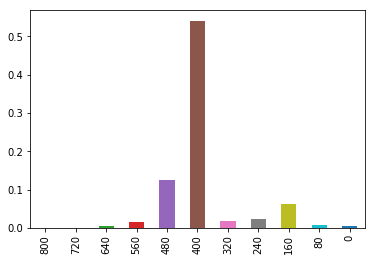

In [613]:
df0.mvs.plot.bar()